In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
from VoiceData import VoiceDataSet

In [3]:
# https://medium.com/analytics-vidhya/pytorch-for-deep-learning-lstm-for-sequence-data-d0708fdf5717

from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from tqdm import tqdm

data_folder = "/Users/will/Documents/COM4511/ass/COM4511/task4VAD/audio"
labs_folder = "/Users/will/Documents/COM4511/ass/COM4511/task4VAD/labels"

training_prefixes = ["N", "V"]
validation_prefixes = ["E"]
testing_prefixes = ["C"]

# reading training data

def read_data_to_list(prefixes):
    data_out = []
    labs_out = []
    os.chdir(data_folder)
    for file in os.listdir():
        if file[0] in prefixes:
            path = f"{data_folder}/{file}"
            with open(path, 'rb') as f:
                data_out.append(np.load(f))
    
    os.chdir(labs_folder)
    for file in os.listdir():
        if file[0] in prefixes:
            path = f"{labs_folder}/{file}"
            with open(path, 'rb') as f:
                labs_out.append(np.load(f))
                
    return data_out, labs_out
    
def calc_means_std(prefixes):
    a_paths, l_paths = VoiceDataSet.gen_paths(VoiceDataSet,prefixes=prefixes)
    a_data, l_data = [], []
    
    for a, l in zip(a_paths, l_paths):
        temp_d, temp_l = VoiceDataSet.read_data_from_path(VoiceDataSet, a, l)
        a_data.append(temp_d)
    
    total_data = torch.cat(a_data)
    
    stds, means = torch.std_mean(total_data, dim=0)
    
    return stds, means
    
    
    

training_stds, training_means = calc_means_std(training_prefixes)

    
training_data, training_labs =  read_data_to_list(training_prefixes)

testing_data, testing_labs =  read_data_to_list(testing_prefixes)
validation_data, validation_labs =  read_data_to_list(validation_prefixes)



class Timeseries(Dataset):
    def __init__(self, x, y, seq_len):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)
        self.len = x.shape[0]
        self.seq_len = seq_len
    
    # def __getitem__(self, idx):
    #     return self.transform(self.x[idx]), self.transform(self.y[idx])

    def __getitem__(self, idx):
        return self.x[idx:idx+self.seq_len], torch.tensor(self.y[idx:idx+self.seq_len], dtype=torch.float32)


    def __len__(self):
        return self.len - (self.seq_len - 1)





# train_datasets = [Timeseries(x, y, seq_len=sequence_length) for (x, y) in zip(training_data, training_labs)]

from torch.utils.data import DataLoader

# train_loader = DataLoader(torch.utils.data.ConcatDataset(train_datasets), shuffle=True, batch_size=32) 


In [4]:


torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [36]:


trnsfrm = transforms.Compose([
    transforms.Normalize(training_means, training_stds)]
)


window_length = 2048

VDS = VoiceDataSet("train", window_length=window_length, transform=trnsfrm)

b_size = 8

train_loader = DataLoader(VDS, shuffle=True, batch_size=b_size)
#print(len(train_loader.dataset))

class LSTM_network(nn.Module):
    def __init__(self):
        super(LSTM_network,self).__init__()
        self.lstm = nn.LSTM(input_size=13,hidden_size=13,num_layers=10,batch_first=True)
        self.fc1 = nn.Linear(in_features=13,out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
       # print(f"x :{x.size}")
        output,_status = self.lstm(x)
        #print(f"after lstm: {output.size()}")
        output = self.fc1(output)
        #print(f"after lin layer: {output.size()}")
        output = self.sigmoid(output)
       # print(f"after sigmoid: {output.size()}")
        return output

model = LSTM_network()

In [37]:
# crit = nn.BCELoss() # binary classfication task, BCEL is obvious choice.
# optimiser = optim.Adam(model.parameters(), lr=0.0001) # https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/
# epochs = 1

print(len(train_loader.dataset))

19


In [43]:


#training løøp

model = LSTM_network()
crit = nn.BCELoss() # binary classfication task, BCEL is obvious choice.
optimiser = optim.Adam(model.parameters(), lr=0.001) 

eps = 1e-8
epochs = 500
losses = [0.5]
t =tqdm(range(epochs))
dat_len = len(train_loader.dataset)
for e in t:
    epoch_loss = 0
    for i, (X, y) in enumerate(train_loader):
        y_pred = model(X) # .permute(0, 2, 1)
        
        # .reshape(data_shape)
        loss = crit(y_pred, y) #.permute(0, 2, 1)
        # optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()
        
    if e % 5 == 0:    
        epoch_loss /=  dat_len
        losses.append(epoch_loss)
        t.set_description(desc=f"Epoch: {e}, loss: {round(epoch_loss, 5)}")
        
    if abs(losses[-1] - losses[-2]) < eps:
        break
                
       

Epoch: 110, loss: 0.06935:  22%|██▏       | 111/500 [17:45<1:03:35,  9.81s/it]

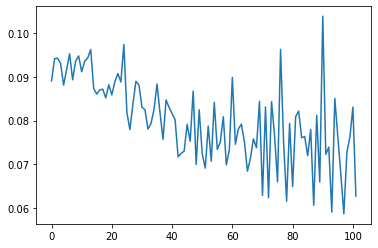

In [ ]:
plt.plot(losses)
plt.show()